In [1]:
import sys
print('Python version: ', sys.version)

Python version:  3.7.4 (default, Nov 22 2019, 15:36:53) 
[Clang 7.3.0 (clang-703.0.31)]


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Import MTA Data

In [3]:
# mta_data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_200104.txt')
with open('project_data.txt') as files:
    files = [f.strip('\n') for f in files]

# Read files into dataframes, parsing dates and times
dfs = [pd.read_csv(file, parse_dates={'DATETIME':['DATE', 'TIME']}) for file in files]
# Combine all dataframes into one
mta_data = pd.concat(dfs)
raw_backup_data = mta_data.copy(deep=True)

## Cleaning the data

In [4]:
# Remove extra whitespace from column names
mta_data.columns = [c.strip() for c in mta_data.columns]

# Create ID column by combining all turnstile identifiers
mta_data['ID'] = mta_data['C/A'] + mta_data['UNIT'] + mta_data['SCP'] + mta_data['STATION']
mta_data.ID.size

1421855

Are there any turnstiles with multiple entries at a single time?

These would be duplicate values and should be removed so they don't affect our analysis.

In [5]:
mta_data.groupby(['ID', 'DATETIME']).ENTRIES.count().sort_values(ascending=False).value_counts()
# Looks like we have some duplicate data.

1    1421815
2         20
Name: ENTRIES, dtype: int64

In [6]:
mta_data = mta_data.drop_duplicates(subset=['ID', 'DATETIME'])

mta_data.groupby(['ID', 'DATETIME']).ENTRIES.count().value_counts()

1    1421835
Name: ENTRIES, dtype: int64

Each `(ID, DATETIME)` pair now has a single number of entries associated with it.

## Average Entries Per Day

Entries on each day are calculated by taking the number of entries at the end of one day, and subtracting the number of entries at the end of the previous day.

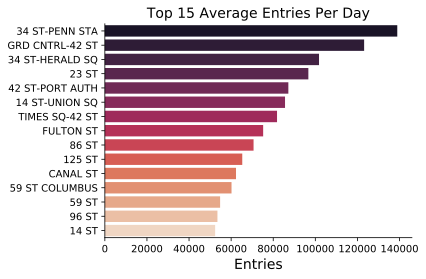

In [7]:
daily_diffs = mta_data.groupby(['ID', 'STATION', pd.Grouper(key='DATETIME', freq='D')]).ENTRIES.max().diff().reset_index()

# The first day must be removed because the first day data has no previous day to subtract
first_day = daily_diffs.DATETIME.min()
daily_diffs = daily_diffs[daily_diffs.DATETIME > first_day]

# Some rows have negative values for entries. These may represent turnstiles that are incrementing backwards.
# We will flip those values so all our entries are positive.
neg_vals_index = daily_diffs[daily_diffs.ENTRIES < 0].index
daily_diffs.loc[neg_vals_index, 'ENTRIES'] *= -1

# Drop turnstiles with daily counts >= 10,000
# We believe it is highly unlikely that any single turnstile will see 10,000 entries in a single day
daily_diffs = daily_diffs[daily_diffs.ENTRIES < 10000]

# Calculate total entries at each station each day
daily_total = daily_diffs.groupby(['STATION','DATETIME']).sum().reset_index()

# Calculate average daily entries at each station, and sort
daily_average = daily_total.groupby('STATION').ENTRIES.mean().to_frame()
daily_avg_sorted = daily_average.sort_values('ENTRIES', ascending=False)

sns.barplot(x=daily_avg_sorted.iloc[:15,0], y=daily_avg_sorted.index[:15], palette='rocket')
sns.despine()
plt.title('Top 15 Average Entries Per Day', fontsize=14)
plt.xlabel('Entries', fontsize=14)
plt.ylabel('')
plt.tight_layout()
# plt.savefig('avg_per_day.svg');

## Average Entries Per Weekday

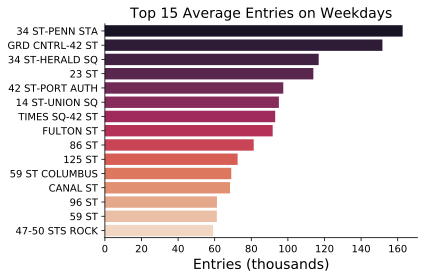

In [8]:
# Add a weekday column to allow us to sort our data by day of the week.
# Weekdays are indexed 0-6, Monday-Sunday
daily_total['WEEKDAY'] = daily_total.DATETIME.dt.weekday

# We want to restrict our investigation to weekdays, so we filter out rows with weekday > 5
# because indices 5, 6 are Saturday and Sunday
weekday_total = daily_total[daily_total.WEEKDAY < 5]

weekday_average = weekday_total.groupby('STATION').ENTRIES.mean().to_frame()
wd_avg_sorted = weekday_average.sort_values('ENTRIES', ascending=False)

sns.barplot(x=wd_avg_sorted.iloc[:15,0]/1000, y=wd_avg_sorted.index[:15], palette='rocket')
sns.despine()
plt.title('Top 15 Average Entries on Weekdays', fontsize=14)
plt.xlabel('Entries (thousands)', fontsize=14)
plt.ylabel('')
plt.tight_layout()
# plt.savefig('avg_weekdays.svg', transparent=True);

## Average Entries on Each Weekday

Text(38.623750000000015, 0.5, 'Entries (thousands)')

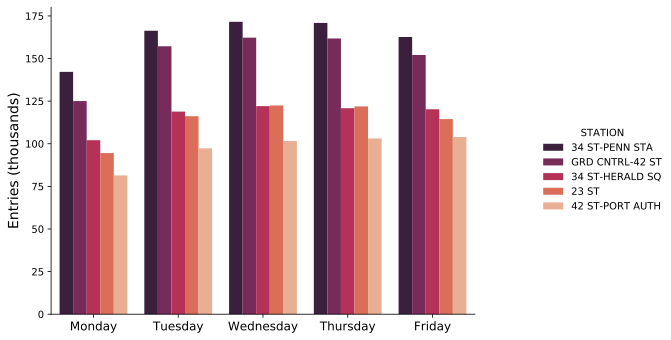

In [9]:
# We want to look specifically the stations with the 5 highest average entries,
# so we pull out the data for those stations.
top5 = wd_avg_sorted.index[:5]

# Using the list of top 5 busiest stations, we construct a DataFrame with each row
# representing average entries for each day of the week, and each colunm representing
# a single station
top5_df = pd.DataFrame()
for station in top5:
    top5_df[station] = weekday_total[weekday_total.STATION == station].groupby('WEEKDAY').ENTRIES.mean()
top5_df.reset_index(inplace=True)

# Change the days of the week from numbers to words
top5_df['WEEKDAY'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Melting the DataFrame creates a new DataFrame with a row for each combination of
# weekday, station, and entries.
top5_melt = top5_df.melt(id_vars='WEEKDAY', var_name='STATION', value_name='ENTRIES')

# We chose to divide all the entries by 1,000 to make the labels on our plot easier to read
top5_melt.loc[:,'ENTRIES'] /= 1000

b = sns.catplot(x='WEEKDAY', y='ENTRIES', hue='STATION', data=top5_melt, kind='bar', palette='rocket')
b.fig.set_figwidth(10)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.ylabel('Entries (thousands)', fontsize=14)
# plt.savefig('top5_weekdays.svg', transparent=True);

## Busiest times for top 2 

In [12]:
# To look even more closely at the top 2 busiest stations, extract their names
top2 = wd_avg_sorted.index[:2]

# We want to look at the data by time now, not only on a daily scale, so we need
# to go back to our original data and work from there
top2_data = mta_data[mta_data.STATION.isin(top2)]
top2_diff = top2_data.groupby(['ID', 'STATION', 'DATETIME']).ENTRIES.max().diff().reset_index()

# We flip negatives and drop turnstiles with more than 10,000 entries in one sample
top2_diff = top2_diff[top2_diff.DATETIME.dt.date > first_day]
neg_vals_index = top2_diff[top2_diff.ENTRIES < 0].index
top2_diff.loc[neg_vals_index, 'ENTRIES'] *= -1
top2_diff = top2_diff[top2_diff.ENTRIES < 10000]

top2_diff = top2_diff.groupby(['STATION', 'DATETIME']).sum().reset_index()

# We are only interested in weekdays, so we add a column for day of the week
# and filter out rows on Saturdays and Sundays
top2_diff['WEEKDAY'] = top2_diff.DATETIME.dt.weekday
top2_diff = top2_diff[top2_diff.WEEKDAY < 5]

# We group by station and time, calculating the average entries at regular 2 hour intervals
top2_bytime = top2_diff.groupby(['STATION', pd.Grouper(key='DATETIME', freq='2H')]).mean().reset_index()

# Adding a column for time will help make nicer-looking plots
top2_bytime['TIME'] = top2_bytime.DATETIME.dt.time
top2_bytime = top2_bytime.groupby(['STATION', 'TIME']).ENTRIES.mean().reset_index()

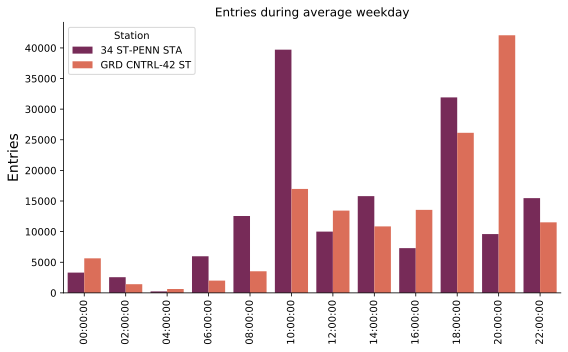

In [13]:
b = sns.catplot(x='TIME', y='ENTRIES', hue='STATION', data=top2_bytime, kind='bar', palette='rocket', legend=False)
b.fig.set_figwidth(8)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Entries', fontsize=14)
plt.title('Entries during average weekday')
plt.legend(title='Station')
plt.tight_layout()
# plt.savefig('avg_weekday_time.svg', transparent=True);